In [549]:
import os
import polars as pl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from hampel import hampel
from datetime import datetime, timezone
from typing import Literal
import glob

from utils import ambient_parameter_conversion as apc
from utils import calibration_processing as cp

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
THINGSBOARD_DATA_PATH = os.environ.get("THINGSBOARD_DATA_PATH")

ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# customize pipeline
outlier_removal = True

In [550]:
def plot_column_difference(df: pl.DataFrame, datetime_col: str, col1: str, col2: str, sample_size: int = 10000, filter_value: int = 10):
    """
    Plots the difference between two columns over a datetime index.
    
    Parameters:
    - df (pl.DataFrame): The Polars DataFrame containing the columns.
    - datetime_col (str): The column name for datetime values.
    - col1 (str): The first column name.
    - col2 (str): The second column name.
    - sample_size (int): Number of points to sample for plotting (default=10,000).
    """
    # Ensure columns exist
    for col in [datetime_col, col1, col2]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Convert datetime column to proper format if needed
    if not isinstance(df[datetime_col].dtype, pl.Datetime):
        df = df.with_columns(pl.col(datetime_col).cast(pl.Datetime).alias(datetime_col))

    # Compute the difference
    df = df.with_columns((pl.col(col1) - pl.col(col2)).alias("difference")) \
        .filter(pl.col("difference") < filter_value) \
        .filter(pl.col("difference") > -filter_value)

    # Downsampling for large data
    num_rows = df.height
    if num_rows > sample_size:
        indices = np.linspace(0, num_rows - 1, sample_size, dtype=int)
        df_sampled = df[indices]
    else:
        df_sampled = df

    # Convert datetime to Python datetime for Matplotlib compatibility
    x_values = df_sampled[datetime_col].to_numpy()
    y_values = df_sampled["difference"].to_numpy()

    # Plot the difference with datetime on x-axis
    plt.figure(figsize=(12, 5))
    plt.plot(x_values, y_values, label=f"{col1} - {col2}", alpha=0.7, linewidth=1)

    # Format the x-axis for datetime
    plt.xlabel("Datetime")
    plt.ylabel("Difference")
    plt.title(f"Difference Between {col1} and {col2} Over Time")
    plt.legend()
    plt.grid(True)
    
    # Format date ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)

    plt.show()

# Import data files

In [551]:
# load calibration bottle concentrations (preprocessed)
df_gas = pl.read_csv(os.path.join(DATA_DIRECTORY,"input", "averaged_gases.csv"))

In [552]:
# Import system specific raw data
def import_system_data(id: int) -> pl.DataFrame:
    paths = []
    df_years = []

    for year in [2024,2025]:
        paths += sorted(glob.glob(os.path.join(THINGSBOARD_DATA_PATH, str(year), f"acropolis-{id}.parquet")), key=os.path.getmtime)
        
    for path in paths:
        df_years.append(pl.scan_parquet(path))

    return pl.concat(df_years, how="diagonal").with_columns(system_id =  pl.lit(id))
    

In [553]:
df_raw = import_system_data(id = 3)
    #.filter(~pl.col("datetime").is_between(datetime(2025, 2, 13, 13, 0, 0), datetime(2025, 2, 17, 12, 0, 0))) 

df_raw.head(1).collect().vstack(df_raw.tail(1).collect())

ts,gmp343_raw,gmp343_compensated,gmp343_filtered,gmp343_temperature,bme280_temperature,bme280_humidity,bme280_pressure,sht45_temperature,sht45_humidity,enclosure_bme280_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_disk_usage,raspi_cpu_usage,raspi_memory_usage,ups_powered_by_grid,ups_battery_is_fully_charged,ups_battery_error_detected,ups_battery_above_voltage_threshold,wxt532_direction_min,wxt532_direction_avg,wxt532_direction_max,wxt532_speed_min,wxt532_speed_avg,wxt532_speed_max,wxt532_last_update_time,wxt532_temperature,wxt532_heating_voltage,wxt532_supply_voltage,wxt532_reference_voltage,cal_bottle_id,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,cal_gmp343_temperature,cal_bme280_temperature,cal_bme280_humidity,cal_bme280_pressure,cal_sht45_temperature,cal_sht45_humidity,datetime,system_name,gmp343_edge_corrected,gmp343_edge_dry,cal_gmp343_slope,cal_gmp343_intercept,cal_sht_45_offset,system_id
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ms],str,f64,f64,f64,f64,f64,i32
1705065713020,null,null,null,null,null,null,null,null,null,25.07,16.96,968.06,59.4,0.301,0.041,0.173,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2024-01-12 13:21:53.020,"""tum-esm-midcost-raspi-3""",null,null,null,null,null,3
1740139222570,394.6,469.5,468.5,42.6,39.73,7.56,945.86,39.85,12.1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2025-02-21 12:00:22.570,"""acropolis-3""",447.3,473.6,null,null,null,3


In [554]:
#extract wind data from df_raw
df_wind = df_raw.select(pl.col("datetime", "system_id", "^(wxt532_.*)$")) \
    .filter(pl.col('wxt532_direction_avg') > 0) \
    .sort("datetime") \
    .collect()
    
df_wind.head(1).vstack(df_wind.tail(1))

datetime,system_id,wxt532_direction_min,wxt532_direction_avg,wxt532_direction_max,wxt532_speed_min,wxt532_speed_avg,wxt532_speed_max,wxt532_last_update_time,wxt532_temperature,wxt532_heating_voltage,wxt532_supply_voltage,wxt532_reference_voltage
datetime[ms],i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-02-20 11:20:57.510,3,11.0,286.1,358.0,1.7,4.0,6.3,1.7084e9,null,null,null,null
2024-11-25 16:34:37.400,3,24.0,136.2,306.0,0.1,0.5,1.0,1.7326e9,null,null,null,null


In [555]:
# extract auxiliary data from df_raw
df_aux = df_raw.select(pl.col("datetime", "system_id", "^(enclosure_.*)$", "^(raspi_.*)$", "^ups_.*$")) \
    .filter(pl.col('enclosure_bme280_temperature') > 0) \
    .sort("datetime") \
    .collect()
    
df_aux.head(1).vstack(df_aux.tail(1))

datetime,system_id,enclosure_bme280_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_disk_usage,raspi_cpu_usage,raspi_memory_usage,ups_powered_by_grid,ups_battery_is_fully_charged,ups_battery_error_detected,ups_battery_above_voltage_threshold
datetime[ms],i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1970-01-21 01:20:21.892,3,20.17,25.81,966.24,39.4,0.672,0.018,0.131,1.0,1.0,0.0,1.0
2025-02-21 12:00:12.609,3,26.82,20.37,962.56,47.7,0.24,0.03,0.08,1.0,1.0,0.0,0.0


In [556]:
#extract wind data from df_raw
df_cal_edge = df_raw.select(pl.col("datetime", "system_id", "cal_gmp343_slope", "cal_gmp343_intercept", "cal_sht_45_offset")) \
    .filter(pl.col('cal_gmp343_slope') > 0) \
    .sort("datetime") \
    .collect()
    
df_cal_edge.head(1).vstack(df_cal_edge.tail(1))

datetime,system_id,cal_gmp343_slope,cal_gmp343_intercept,cal_sht_45_offset
datetime[ms],i32,f64,f64,f64
2025-02-13 14:47:34,3,0.99,-23.0,1.52
2025-02-21 02:31:56.833,3,0.99,-21.79,1.47


In [557]:
# extract measurement data from df_raw and aggregate to 1m 
df_1_m = df_raw.sort("datetime") \
    .select(pl.all().exclude('^wxt532_.*$', '^cal_.*$', '^enclosure_.*$', '^raspi_.*$', '^ups_.*$')) \
    .filter(pl.col('gmp343_filtered') > 0) \
    .filter(pl.col('gmp343_temperature') > 0) \
    .filter(pl.col('sht45_humidity') > 0) \
    .filter(pl.col('bme280_pressure') > 0) \
    .group_by_dynamic("datetime", every='1m', group_by= "system_id") \
    .agg(pl.all().exclude(["datetime","system_id"]).mean()) \
    .collect()
    
df_1_m.head(1).vstack(df_1_m.tail(1))

system_id,datetime,ts,gmp343_raw,gmp343_compensated,gmp343_filtered,gmp343_temperature,bme280_temperature,bme280_humidity,bme280_pressure,sht45_temperature,sht45_humidity,system_name,gmp343_edge_corrected,gmp343_edge_dry
i32,datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64
3,1970-01-21 01:20:00,1.7328e9,394.3,464.211538,463.769231,42.457692,40.267308,8.333846,951.552308,40.239615,18.14,null,null,null
3,2025-02-21 12:00:00,1.7401e12,394.566667,469.3,469.5,42.633333,39.726667,7.566667,944.626667,39.853333,12.093333,null,448.3,474.666667


In [558]:
# extract calibration data from df_raw
df_dry_calibration = df_raw.filter(pl.col("cal_gmp343_filtered") > 0) \
    .filter(pl.col("cal_gmp343_temperature") > 0) \
    .filter(pl.col("cal_bme280_pressure") > 0) \
    .with_columns(pl.col("cal_sht45_humidity").fill_null(0.0)) \
    .with_columns(pl.struct(['cal_gmp343_temperature','cal_sht45_humidity','cal_bme280_pressure'])
    .map_elements(lambda x: apc.rh_to_molar_mixing(x['cal_sht45_humidity'],apc.absolute_temperature(x['cal_gmp343_temperature']),x['cal_bme280_pressure']*100), return_dtype=pl.Float64) \
    .alias("cal_h2o_v%")) \
    .with_columns(pl.struct(['cal_gmp343_filtered','cal_gmp343_temperature','cal_sht45_humidity','cal_bme280_pressure']) \
    .map_elements(lambda x: apc.calculate_co2dry(x['cal_gmp343_filtered'],x['cal_gmp343_temperature'],x['cal_sht45_humidity'],x['cal_bme280_pressure']*100), return_dtype=pl.Float64)
    .alias("cal_gmp343_dry")) \
    .select("datetime","system_id", '^cal_.*$') \
    .filter((pl.col("cal_bottle_id") > 0) & (pl.col("cal_bottle_id") <= df_gas["cal_bottle_id"].max())) \
    .collect()
    
df_dry_calibration.head(1).vstack(df_dry_calibration.tail(1))

/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/notebooks/utils/ambient_parameter_conversion.py:93: RuntimeWarning:

overflow encountered in scalar multiply

/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/notebooks/utils/ambient_parameter_conversion.py:93: RuntimeWarning:

overflow encountered in scalar multiply

/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/notebooks/utils/ambient_parameter_conversion.py:93: RuntimeWarning:

overflow encountered in scalar multiply

/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/notebooks/utils/ambient_parameter_conversion.py:93: RuntimeWarning:

overflow encountered in scalar multiply

/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/notebooks/utils/ambient_parameter_conversion.py:93: RuntimeWarning:

overflow encountered in scalar multiply



datetime,system_id,cal_bottle_id,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,cal_gmp343_temperature,cal_bme280_temperature,cal_bme280_humidity,cal_bme280_pressure,cal_sht45_temperature,cal_sht45_humidity,cal_gmp343_slope,cal_gmp343_intercept,cal_sht_45_offset,cal_h2o_v%,cal_gmp343_dry
datetime[ms],i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-01-12 15:18:38.070,3,54.0,490.4,550.5,565.7,23.8,20.23,10.03,957.02,20.36,11.82,null,null,null,0.003643,567.768664
2025-02-21 02:31:22.438,3,82.0,0.0,-2.3215e-185,551.0,42.6,-2.3215e-185,-2.3215e-185,957.85,0.0,0.0,null,null,null,0.0,551.0


In [559]:
df_raw = None

# Perform Dry-Wet Conversion

### Measurement Data

In [560]:
# perform dry conversion for measurement data                
df_1_m = df_1_m.with_columns(pl.struct(['gmp343_temperature','sht45_humidity']) \
    .map_elements(lambda x: apc.rh_to_ah(x['sht45_humidity'],apc.absolute_temperature(x['gmp343_temperature'])), return_dtype=pl.Float64)
    .alias("h2o_ah")) \
    .with_columns(pl.struct(['gmp343_temperature','sht45_humidity','bme280_pressure'])
    .map_elements(lambda x: (apc.rh_to_molar_mixing(x['sht45_humidity'],apc.absolute_temperature(x['gmp343_temperature']),x['bme280_pressure']*100))*100, return_dtype=pl.Float64) \
    .alias("h2o_v%")) \
    .with_columns(pl.struct(['gmp343_temperature','bme280_humidity','bme280_pressure'])
    .map_elements(lambda x: (apc.rh_to_molar_mixing(x['bme280_humidity'],apc.absolute_temperature(x['gmp343_temperature']),x['bme280_pressure']*100))*100, return_dtype=pl.Float64) \
    .alias("bme280_h2o_v%")) \
    .with_columns(pl.struct(['gmp343_filtered','gmp343_temperature','sht45_humidity','bme280_pressure']) \
    .map_elements(lambda x: apc.calculate_co2dry(x['gmp343_filtered'],x['gmp343_temperature'],x['sht45_humidity'],x['bme280_pressure']*100), return_dtype=pl.Float64)
    .alias("gmp343_dry"))

In [561]:
df_1_m.tail(3).select("datetime","system_id","gmp343_filtered", "h2o_ah", "h2o_v%" ,"gmp343_edge_dry", "gmp343_dry")

datetime,system_id,gmp343_filtered,h2o_ah,h2o_v%,gmp343_edge_dry,gmp343_dry
datetime[ms],i32,f64,f64,f64,f64,f64
2025-02-21 11:58:00,3,467.4,7.018371,1.081728,472.516667,472.511288
2025-02-21 11:59:00,3,466.366667,7.023084,1.083838,471.466667,471.476708
2025-02-21 12:00:00,3,469.5,7.042496,1.086523,474.666667,474.657258


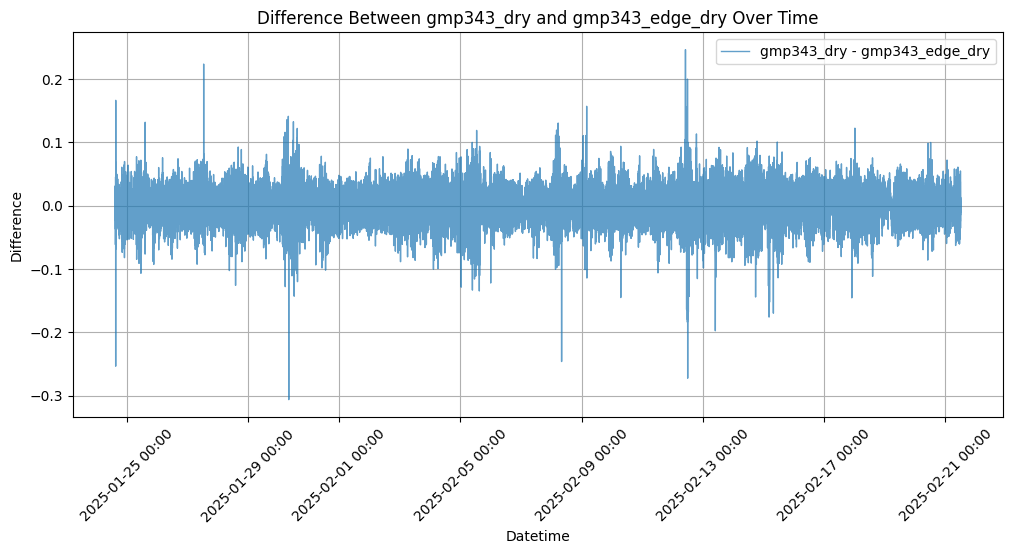

In [562]:
plot_column_difference(df_1_m, datetime_col="datetime", col1="gmp343_dry", col2="gmp343_edge_dry", sample_size=100_000)

# Calculate Calibration Correction

In [563]:
df_slope_intercept = df_dry_calibration \
    .join(df_gas.cast({"cal_bottle_id": pl.Float64}), on=["cal_bottle_id"], how="left", coalesce=True) \
    .with_columns((pl.col("datetime").dt.date()).alias("date")) \
    .sort("date") \
    .group_by(["date", "system_id", "cal_bottle_id"]) \
    .agg([
        pl.col("cal_gmp343_dry"),
        pl.col("cal_bottle_CO2").last(),
        pl.col("datetime").last(),
    ]) \
    .with_columns([
        pl.col("cal_gmp343_dry").map_elements(lambda x: cp.process_bottle(x), return_dtype=pl.Float64)
    ]) \
    .filter(pl.col("cal_gmp343_dry") > 0) \
    .sort(pl.col("cal_gmp343_dry")) \
    .group_by(["date", "system_id"]) \
    .agg([
        pl.col("cal_gmp343_dry"),
        pl.col("cal_bottle_CO2"),
        pl.col("datetime").last()
    ]) \
    .filter(pl.col("cal_gmp343_dry").list.len() == 2) \
    .with_columns(
    pl.struct(["cal_gmp343_dry", "cal_bottle_CO2"])
    .map_elements(lambda x: cp.two_point_calibration(x["cal_gmp343_dry"], x["cal_bottle_CO2"]), return_dtype=pl.Struct)
    .alias("slope_intercept"))  \
    .with_columns([
        pl.col("slope_intercept").struct.field("slope").alias("slope"),
        pl.col("slope_intercept").struct.field("intercept").alias("intercept")
    ]) \
    .select("datetime", "system_id", "slope", "intercept") \
    .filter(pl.col("slope") > 0.9) \
    .filter(pl.col("slope") < 1.1) \
    .sort("datetime")

In [564]:
df_slope_intercept.head(1).vstack(df_slope_intercept.tail(1))

datetime,system_id,slope,intercept
datetime[ms],i32,f64,f64
2024-01-12 15:48:48.510,3,0.981404,-15.809397
2025-02-21 02:31:22.438,3,0.991134,-22.137929


In [565]:
fig = px.line(df_slope_intercept.sort("datetime").filter((pl.col("slope") > -2) & (pl.col("slope") < 2)), x="datetime", y = "slope", color = "system_id")
fig.show()
fig = px.line(df_slope_intercept.sort("datetime").filter((pl.col("intercept") > -100) & (pl.col("intercept") < 100)), x="datetime", y = "intercept", color = "system_id")
fig.show()

# Perform Calibration Correction

## 1m aggregated data

In [566]:
PICARRO_DIR = "/Users/patrickaigner/Documents/PROJECTS/acropolis-visualisation/data/processed/picarro/Calibrated_1_min_ICOS_Picarro_G2401_529.parquet"

df_p_icos = pl.read_parquet(PICARRO_DIR)

start_date = datetime(2025, 1, 1, 0, 0, 0)
end_date = datetime(2025, 2 , 28, 0, 0, 0)

df_p_icos = df_p_icos.rename({"creation_timestamp": "datetime", "picarro_corrected": "CO2"}) \
    .select(["datetime", "CO2"]) \
    .with_columns(pl.col("datetime").cast(pl.Datetime("ms"))) \
    .filter(pl.col("datetime").is_between(start_date, end_date)) \
    .with_columns(system_name = pl.lit("Picarro_ICOS")) \
    .with_columns(system_id = pl.lit(529)) \
    .with_columns(pl.col("system_id").cast(pl.Int64))

In [571]:
df_1_m = df_1_m.sort("datetime") \
.join_asof(df_slope_intercept, on="datetime", strategy="nearest", tolerance="10m") \
.join_asof(df_wind, on="datetime", strategy="nearest", tolerance="10m") \
.join_asof(df_aux, on="datetime", strategy="nearest", tolerance="10m") \
.join_asof(df_cal_edge, on="datetime", strategy="nearest", tolerance="10m") \
.join(df_p_icos, on="datetime") \
.with_columns([
    pl.col("slope").interpolate().alias("slope_interpolated"),
    pl.col("intercept").interpolate().alias("intercept_interpolated")
    ]) \
.with_columns([
    pl.col("slope_interpolated").forward_fill(),
    pl.col("intercept_interpolated").forward_fill(),
    pl.col("cal_gmp343_slope").forward_fill(),
    pl.col("cal_gmp343_intercept").forward_fill()
    ]) \
.with_columns(((pl.col("gmp343_dry")) * pl.col("slope_interpolated") + pl.col("intercept_interpolated")).alias("gmp343_corrected")) \
.with_columns((pl.col("datetime").dt.date()).alias("date"))

In [572]:
df_1_m.head(1).vstack(df_1_m.tail(1))

system_id,datetime,ts,gmp343_raw,gmp343_compensated,gmp343_filtered,gmp343_temperature,bme280_temperature,bme280_humidity,bme280_pressure,sht45_temperature,sht45_humidity,system_name,gmp343_edge_corrected,gmp343_edge_dry,h2o_ah,h2o_v%,bme280_h2o_v%,gmp343_dry,system_id_right,slope,intercept,system_id_right,wxt532_direction_min,wxt532_direction_avg,wxt532_direction_max,wxt532_speed_min,wxt532_speed_avg,wxt532_speed_max,wxt532_last_update_time,wxt532_temperature,wxt532_heating_voltage,wxt532_supply_voltage,wxt532_reference_voltage,system_id_right,enclosure_bme280_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_disk_usage,raspi_cpu_usage,raspi_memory_usage,ups_powered_by_grid,ups_battery_is_fully_charged,ups_battery_error_detected,ups_battery_above_voltage_threshold,system_id_right,cal_gmp343_slope,cal_gmp343_intercept,cal_sht_45_offset,CO2,system_name_right,system_id_right,slope_interpolated,intercept_interpolated,gmp343_corrected,date
i32,datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,str,i64,f64,f64,f64,date
3,2025-01-01 00:00:00,1.7357e12,406.25,481.633333,501.583333,42.6,40.268333,3.92,948.521667,40.225,14.166667,null,null,null,8.236387,1.265366,0.350134,508.011537,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,19.26,18.75,964.81,37.9,0.649,0.016,0.138,1.0,1.0,0.0,1.0,null,null,null,null,478.796615,"""Picarro_ICOS""",529,null,null,null,2025-01-01
3,2025-02-12 23:59:00,1.7394e12,394.133333,473.816667,475.416667,42.6,39.666667,10.065,935.161667,39.801667,14.645,null,455.333333,481.816667,8.514486,1.326778,0.911849,481.809206,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,22.07,29.39,954.22,41.8,0.61,0.03,0.14,1.0,1.0,0.0,0.0,null,null,null,null,454.312907,"""Picarro_ICOS""",529,0.9917,-23.313678,454.496388,2025-02-12


In [573]:
df_temp = df_1_m.filter(pl.col("datetime").is_between(start_date, end_date)).drop("system_id_right") \
    .filter(pl.col("gmp343_corrected") > 400).filter(pl.col("gmp343_corrected") < 1000) 
fig = px.line(df_temp, x="datetime", y = ["gmp343_corrected", "gmp343_edge_corrected", "CO2"])
fig.show()

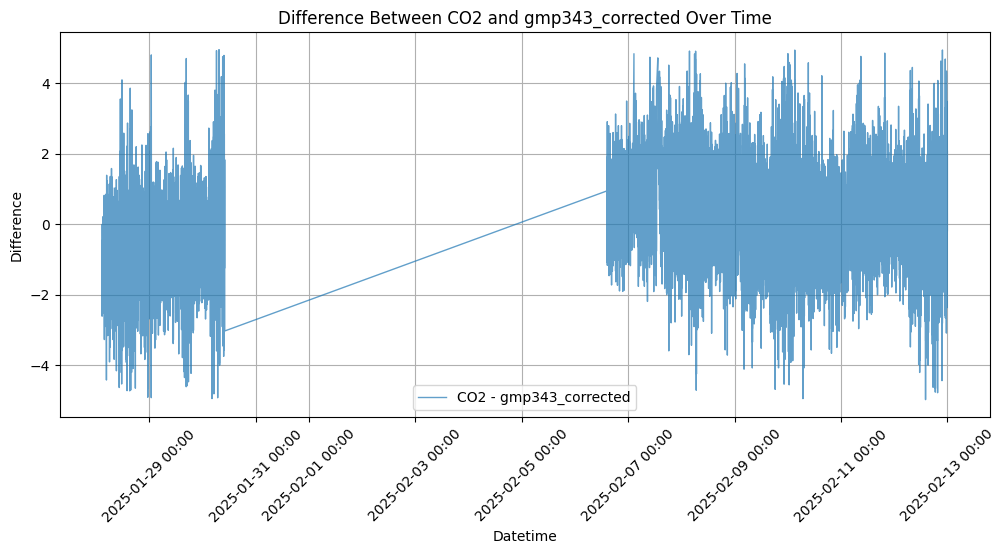

In [574]:
plot_column_difference(df_temp, datetime_col="datetime", col1="CO2", col2="gmp343_corrected", sample_size=100_000, filter_value=5)

In [ ]:
#df_1_m.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "pipeline", "calibrated_1_min_acropolis.parquet"))

## 10m aggregated data

In [ ]:
df_10_m = df_1_m.sort("datetime") \
        .group_by_dynamic("datetime", every='10m', group_by=["system_id", "system_name"]) \
        .agg(pl.all().exclude(["datetime","system_name"]).mean(),
                pl.col("gmp343_corrected").std().alias("std"),
                pl.col("gmp343_corrected").var().alias("var")) 
        
#.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "pipeline", "calibrated_10_min_acropolis.parquet"))

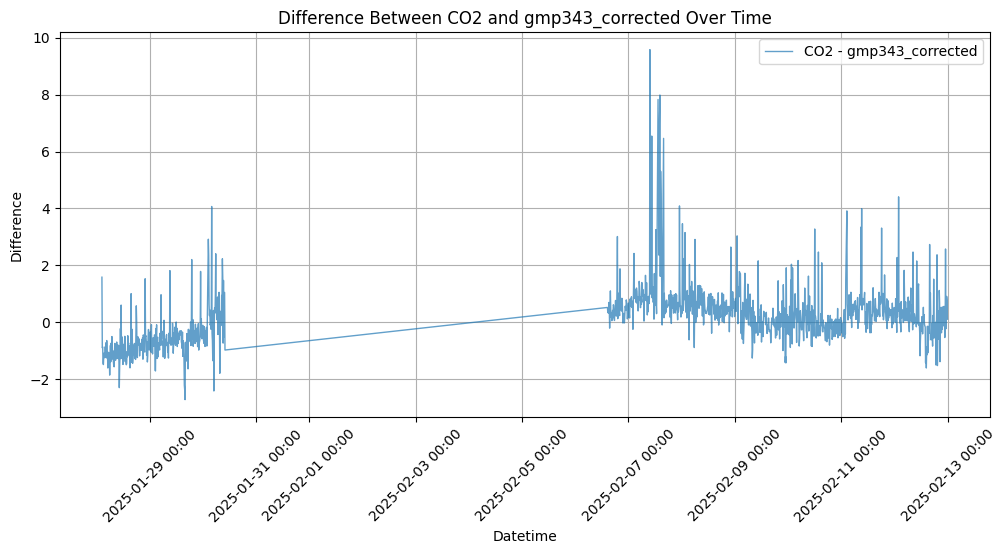

In [577]:
plot_column_difference(df_10_m, datetime_col="datetime", col1="CO2", col2="gmp343_corrected", sample_size=100_000, filter_value=10)

## 1h aggregated data

In [582]:
df_1_h = df_1_m.sort("datetime") \
        .group_by_dynamic("datetime", every='1h', group_by=["system_id", "system_name"]) \
        .agg(pl.all().exclude(["datetime","system_name"]).mean(),
             pl.col("gmp343_corrected").std().alias("std"),
             (pl.col("gmp343_temperature").max() - pl.col("gmp343_temperature").min()).alias("gmp343_temperature_change")) \
#.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "pipeline", "calibrated_1_h_acropolis.parquet"))

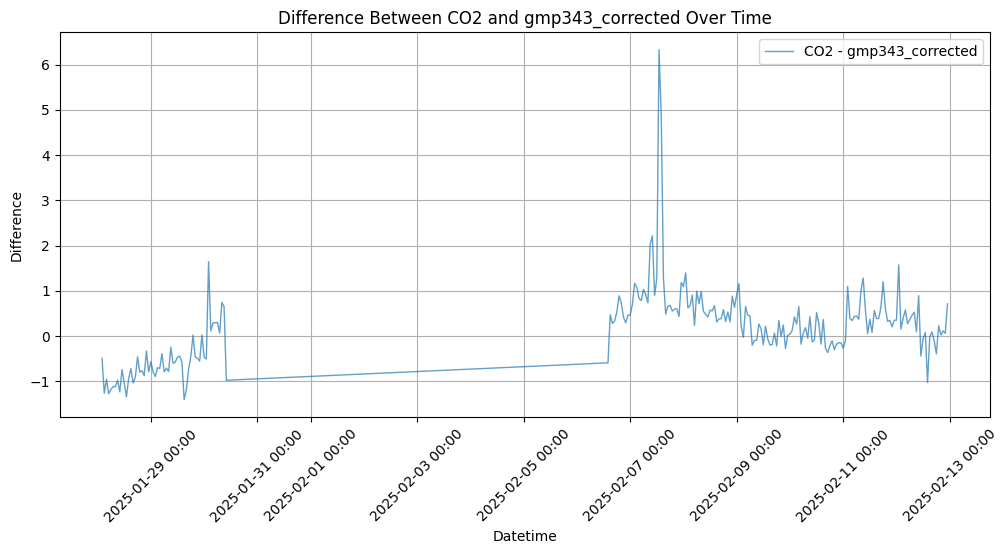

In [583]:
plot_column_difference(df_1_h, datetime_col="datetime", col1="CO2", col2="gmp343_corrected", sample_size=100_000, filter_value=10)

# Renaming and column selection for ICOS cities portal

In [ ]:
assert(outlier_removal)

In [ ]:
df_1_m = pl.read_parquet(os.path.join(DATA_DIRECTORY, "processed", "pipeline", "calibrated_1_min_acropolis.parquet"))

In [ ]:
# Select the columns to be present in the ICOS cities portal product
selected_columns = ["creation_timestamp", "system_id", "sys_name_short", "gmp343_corrected", "gmp343_temperature", "h2o_v%", "bme280_pressure", "enclosure_bme280_pressure", "wxt532_speed_avg", "wxt532_direction_avg"]

df_1_m = df_1_m.select(selected_columns) 

In [ ]:
df_1_m.tail(1)

# Outlier Removal

In [ ]:
df_systems = []
n_sigma = 3.0

for id in sensor_id:
    df_filtered = df_1_m.filter(pl.col("system_id")==id) \
        .cast({"gmp343_corrected": pl.Float32}) \
        .filter(pl.col("gmp343_corrected") > 0)
        #co2 is cast to f32 to match the hampel filter output, else comparison fails
    
    # Convert CO2 column to pandas series 
    data = df_filtered.get_column("gmp343_corrected").to_pandas()
      
    # Apply the Hampel filter  
    result = hampel(data, window_size=120, n_sigma=n_sigma)
    
    # Print share of detected spikes
    print(f"System ID: {id}, Detected spikes: {(len(result.outlier_indices) / len(data)):.4f}")
    
    # Create column "OriginalFlag" = 389 indicating local contamination
    df_system = df_filtered.with_columns((pl.from_pandas(result.filtered_data)).alias("co2_hampel_filtered")) \
        .with_columns(pl.when(pl.col("gmp343_corrected").ne(pl.col("co2_hampel_filtered"))).then(pl.lit('H')).otherwise(pl.lit('U')).alias("Flag")) \
        .drop("co2_hampel_filtered") \
        .cast({"gmp343_corrected": pl.Float64})
    
    df_systems.append(df_system)
    
df_1_m_spike_detected = pl.concat(df_systems, how="vertical")

# Option to add additional OriginalFlags

In [ ]:
# Sensor temperature specific accurcy flag
# df_1_m_spike_detected.with_columns((pl.when((pl.col("gmp343_temperature") < 26.0) | (pl.col("gmp343_temperature") > 32.0)) \
#                                     .then(pl.lit(644)) \
#                                     .otherwise(pl.lit(0)) \
#                                     .alias("OriginalFlag"))).filter(pl.col("OriginalFlag") > 0)

In [ ]:
# save a 1m product for ICOS cities portal
df_1_m_spike_detected.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "pipeline", "flagged_L1_1_min_acropolis.parquet"))

In [ ]:
df_1_m_spike_detected.tail(1)

# Plot Despiked Data with Continous Error Bars

In [ ]:
#df_1_h_despiked= pl.read_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_level_1_cities_portal.parquet"))

In [ ]:
start_date = datetime(2024, 7, 1, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 12, 30, 23, 59, 59).replace(tzinfo=timezone.utc)

def create_figure(df, system_name:str, start_date, end_date, color:Literal["red", "blue", "green"]):
    
    df_plot = df.filter(pl.col("creation_timestamp").is_between(start_date, end_date)) \
        .filter(pl.col("sys_name_short")==system_name) \
        .with_columns(upper = pl.col("gmp343_corrected") + pl.col("Stdev"),
                    lower = pl.col("gmp343_corrected") - pl.col("Stdev"))
    
    
    if color=='red':
        color_set = ('#b91c1c', 'rgba(239, 68, 68, 0.3)')
    if color=='blue':
        color_set = ('#1d4ed8','rgba(59, 131, 246, 0.3)')
    if color=='green':
        color_set = ('#15803d','rgba(34, 197, 94, 0.3)')
    
    return [
        go.Scatter(
            name=system_name,
            x=df_plot["creation_timestamp"],
            y=df_plot["gmp343_corrected"],
            mode='lines',
            line=dict(color=color_set[0]),
        ),
        go.Scatter(
            name='Upper Bound',
            x=df_plot["creation_timestamp"],
            y=df_plot["upper"],
            mode='lines',
            marker=dict(color=color_set[1]),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=df_plot["creation_timestamp"],
            y=df_plot["lower"],
            marker=dict(color=color_set[1]),
            line=dict(width=0),
            mode='lines',
            fillcolor=color_set[1],
            fill='tonexty',
            showlegend=False
        )
    ]
  
figures = create_figure(df_1_h_despiked, "acropolis-14", start_date, end_date, color="red") \
    + create_figure(df_1_h_despiked, "acropolis-7", start_date, end_date, color="green") \
    #+ create_figure(df_1_h_despiked, "acropolis-6", start_date, end_date, color="blue")

fig = go.Figure(figures)
fig.update_layout(
    yaxis_title='CO2 (ppm)',
    xaxis_title='UTC Time (hourly aggregated)',
    title='Continuous, variable value error bars',
    hovermode="x"
)
fig.show()